In [159]:
#python v3.11.3

import warnings
#to suppress seaborn palette warnings
warnings.filterwarnings("ignore", category=UserWarning)
#to suppress seaborn error estimation NaN warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)



import os
import datetime

import numpy as np #v1.25.0
import pandas as pd #v2.0.3
import scipy #v1.10.1
import scipy.stats as stats

import seaborn as sns #v0.13.0
import matplotlib as mpl #v3.8.1
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

#import matplotlib.spines as spines
from matplotlib.patches import Rectangle

# these files should be in the same directory as this Jupyter notebook
from loader import *
from analysis_functions import *

#to suppress inaccurate pandas reassignment warnings
pd.options.mode.chained_assignment = None  # default='warn'

## 1. Load Files

### Parameters

In [160]:
# directory files are pulled from
csv_directory = 'C:\\Users\\swind\\Documents\\lab_work\\Barth\\behavior_analysis\\mouse_analysis\\full_trial_analysis\\sample_data'

# file containing information about animals (cage, age, sex, strain) - must have Animal ID column
metadata_file = 'C:\\Users\\swind\\Documents\\lab_work\\Barth\\behavior_analysis\\mouse_analysis\\full_trial_analysis\\sample_metadata.xlsx'

default_acc_time = 1 # days

### a. Load metadata file

The metadata file allows data from multiple animals with different acclimation 
times to be loaded together. If no metadata is provided, all animals loaded will
be assumed to be acclimated for the `default_acc_time` value. Optional columns
will label each animal with that information and allow splitting data based on
those properties.

If you do not wish to provide metadata, input an empty `.xlsx` file.

Columns used:

- all column names are case sensitive
- column named `Animal ID` (required)
    - this ID must match folder names or lookup will not work
- column named `acc`
    - number of days the animal was acclimated
    - if this value is missing or lookup fails, the `default_acc_time` value will be used
- column named `Age` (optional)
    - age of animal
- column named `Sex` (optional)
    - sex of animal
- column named `Cage` (optional)
    - cage animal was trained in
- column named `Strain` (optional)
    - animal strain

Other columns can be present in the metadata file and will be ignored.

In [161]:
metadata = pd.read_excel(metadata_file)

### b. Load data

In [162]:
# this will load all conditions in a directory of multiple conditions
df = []
for d in os.listdir(csv_directory):
    cond = make_condition_df(csv_directory +'\\' + d, d, metadata, default_acc_time)
    df.append(cond)
df = pd.concat(df)

## 2. Lick Frequency Analysys

### Parameters

In [163]:
time_bin = 4*60 # minutes
# using rolling window
freq_window = None # milliseconds, length of rolling window
freq_bin = 100 # milliseconds, length of discrete time bin

### a. Lick frequency across entire trial

If `freq_window` is not `None` data will be averaged with a rolling window of the
given length. Data will then be averaged into discrete time bins the legnth of
`freq_bin`.

In [164]:
data = lickfreq_analysis(df, freq_window, freq_bin, time_bin)

### b. Just anticipatory licking

The range `r` is inclusive on both sides.

In [165]:
r = (700, 1000)
ant_data = bin_lickfreq_analysis(df, r, time_bin)

## 3. Pre-aggregate analysis (optional)

### a. Group trials into bouts

Bout boundaries are defined as 2 consecutive trials being more than 2 minutes
apart, based on visual investigation of raster plots of 
trial distributions of individual animals.

In [166]:
data = get_bouts(data, ["animal"], "timestamp", "bout no", 2, "min")

### b. Label trials with previous trial identity

Uses bout labels to only look at previous trials within a bout (i.e. that 
happened less than 2 minutes before the current trial).

In [167]:
trial_ind = ["animal", "trial no"]
bout_ind = ["animal", "bout no"]
key = "stimulus"
n = 1
cond0 = "stimulus"
cond1 = "blank"
data = get_n_back(data, trial_ind, bout_ind, key, n, cond0, cond1)

### c. Get trials in given quintile of day

In [168]:
# needs testing, not abstracted
nth_quint = 4 # which quintile (20%) of trials to keep (numbered 0-4)

nth_quint_data = get_nth_quintile(data, nth_quint)

## 4. Aggregation

### Parameters

In [169]:
min_trials = 10 # minimum number of trials in a bin to keep
min_water_trials = 0 # minimum number of water trials
min_blank_trials = 0 # minimum number of water trials

### a. Calculate aggregate values

In [170]:
mean_statistics, counts, perf = aggregate_analysis(data, min_trials, min_blank_trials, min_water_trials, ["day_delta"])

### b. Calculate aggregate values filtered by previous trial identity

untested for `n` $\geq$ `1`

In [171]:
n = 1
mean_w_prev, counts_w_prev, perf_w_prev = agg_by_prev_trial(data, (mean_statistics, counts, perf), n, min_trials, min_blank_trials, min_water_trials, [])

### c. Calculate aggregate values for just anticipatory licking

In [172]:
ant_mean_statistics, ant_counts, ant_perf = bin_aggregate_analysis(ant_data, min_trials, min_blank_trials, min_water_trials, [])

### d. Number of animals in each timebin, by condition

In [173]:
num_per_timebin = counts.groupby(["condition", "animal", "Time (hr)"]).first().reset_index().groupby(["condition","Time (hr)"])["animal"].count().reset_index()
num_per_timebin.set_index(["condition", "Time (hr)"]).unstack("Time (hr)")

animal                                                              \
Time (hr)  -48.0 -44.0 -40.0 -36.0 -32.0 -28.0 -24.0 -20.0 -16.0 -12.0 -8.0    
condition                                                                      
ACC3         1.0   1.0   1.0   1.0   1.0   1.0   NaN   1.0   1.0   1.0   1.0   
SAT1         NaN   1.0   2.0   2.0   2.0   1.0   2.0   2.0   2.0   2.0   2.0   
psSAT1       NaN   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   

                                                           
Time (hr) -4.0   0.0   4.0   8.0   12.0  16.0  20.0  24.0  
condition                                                  
ACC3        1.0   1.0   1.0   1.0   1.0   1.0   1.0   NaN  
SAT1        1.0   NaN   1.0   2.0   2.0   2.0   NaN   1.0  
psSAT1      1.0   1.0   NaN   1.0   1.0   1.0   1.0   1.0

## 6. Plot Examples 

These plots should work if all above code ran correctly, but formatting will
have to custom tailored. All plotting is done using a combination of the
`seaborn` and `matplotlib` modules.

### Set custom matplotlib style sheet

In [174]:
mpl.style.use("C:\\Users\\swind\\Documents\\lab_work\\Barth\\behavior_analysis\\mouse_analysis\\full_trial_analysis\\mouse_analysis.mplstyle")

### Anticipatory licking frequency

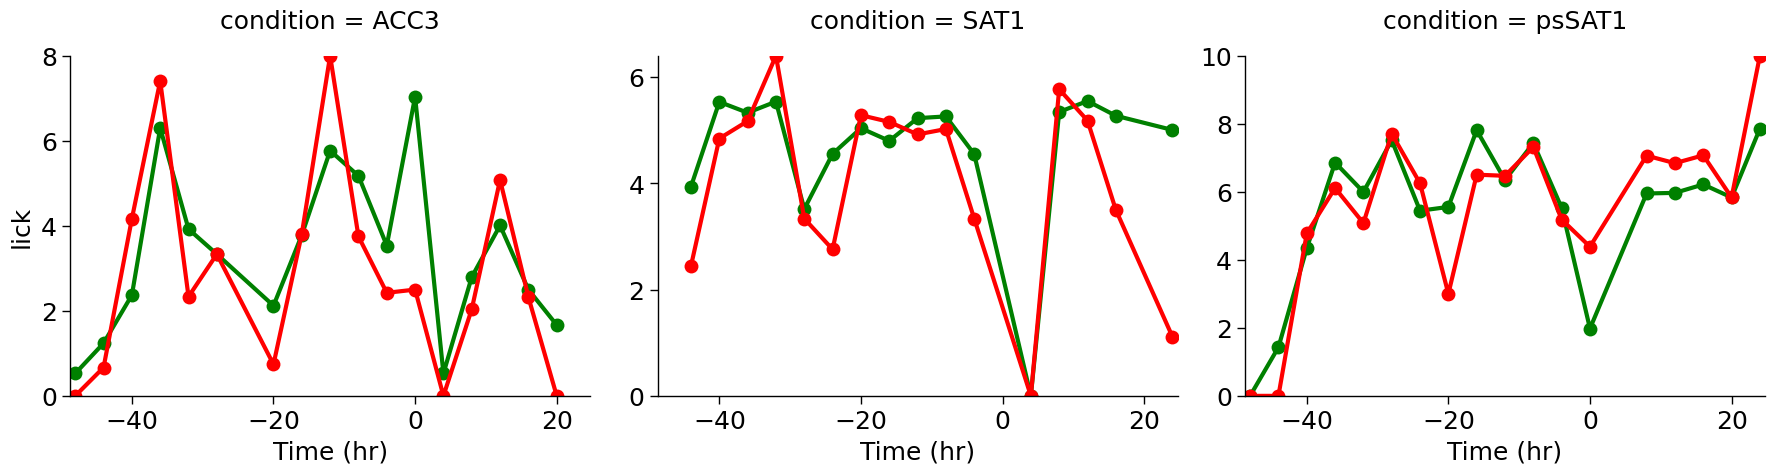

In [175]:
g = sns.relplot(ant_mean_statistics, x="Time (hr)", y="lick", hue="stimulus", 
                col ="condition", palette = ["green", "red"], errorbar=None,
                hue_order=["stimulus", "blank"], kind="line",  aspect=1.2, 
                facet_kws={"sharey":False}, marker='o', mec=None,ms=10, 
                legend=False)

#### anticipatory licking to stimulus bar plot

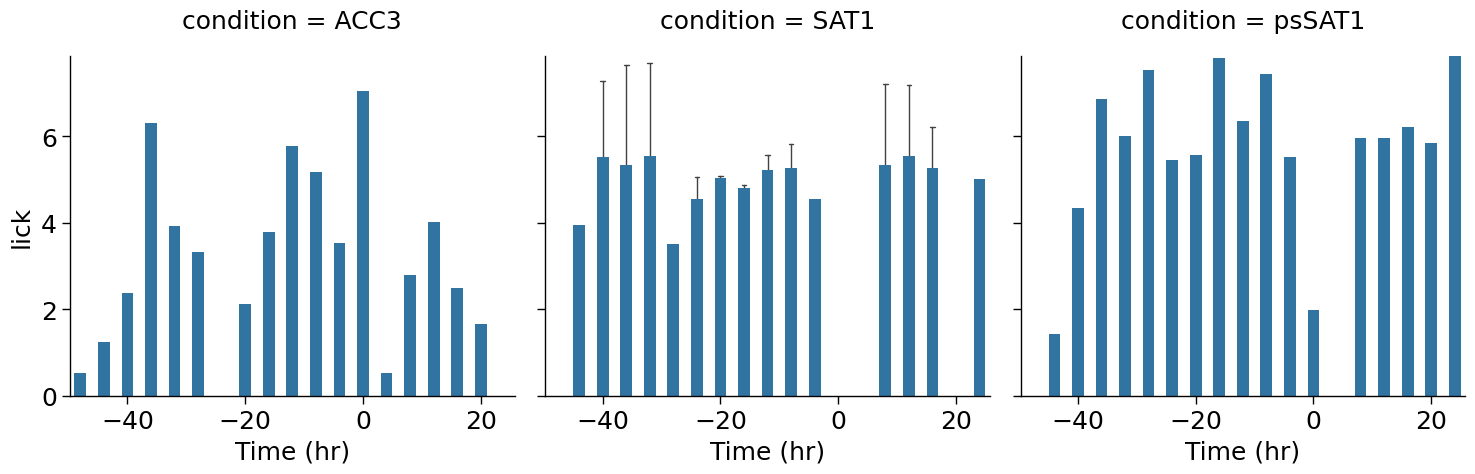

In [176]:
# anticipatory licking to stimulus
cond = (ant_mean_statistics["stimulus"] == "stimulus")
 
g = sns.catplot(ant_mean_statistics[cond], x="Time (hr)", y="lick",
                legend=False, col="condition",
                kind="bar", errorbar="se", dodge=False, capsize=0.2, width=0.5,
                err_kws={"zorder":0, "lw":1},
                sharey=True, sharex=True, native_scale=True)

#### anticipatory licking to blank bar plot

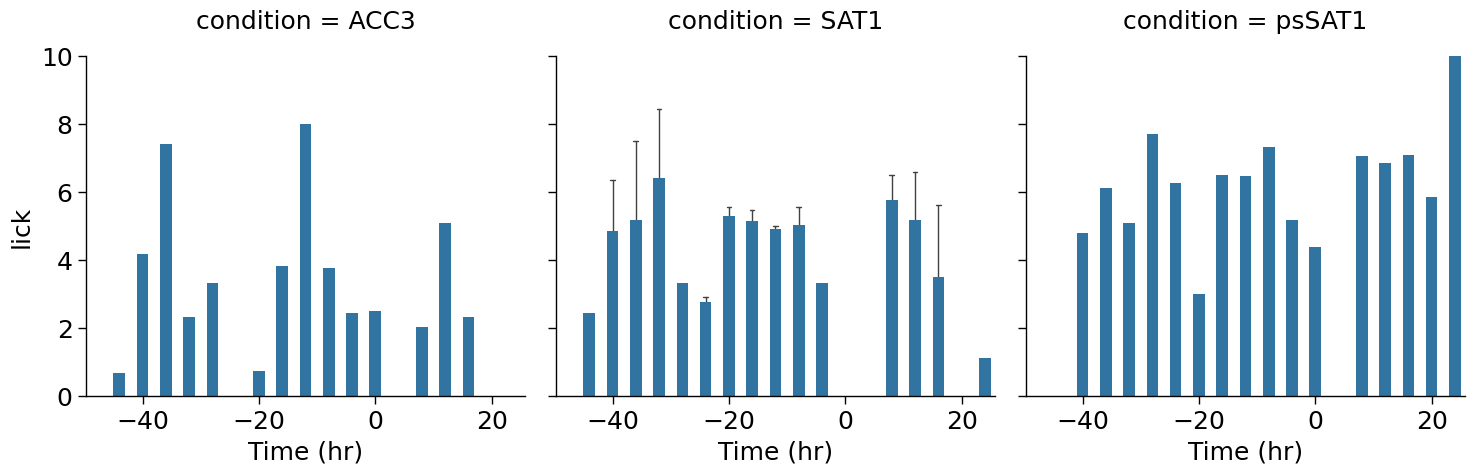

In [177]:
# anticipatory licking to blank
cond = (ant_mean_statistics["stimulus"] == "blank")

g = sns.catplot(ant_mean_statistics[cond], x="Time (hr)", y="lick",
                col="condition", kind="bar", errorbar="se", dodge=False, capsize=0.2, width=0.5,
                err_kws={"zorder":0, "lw":1},
                sharey=True, sharex=True, native_scale=True)

### Performance

#### performance line plot


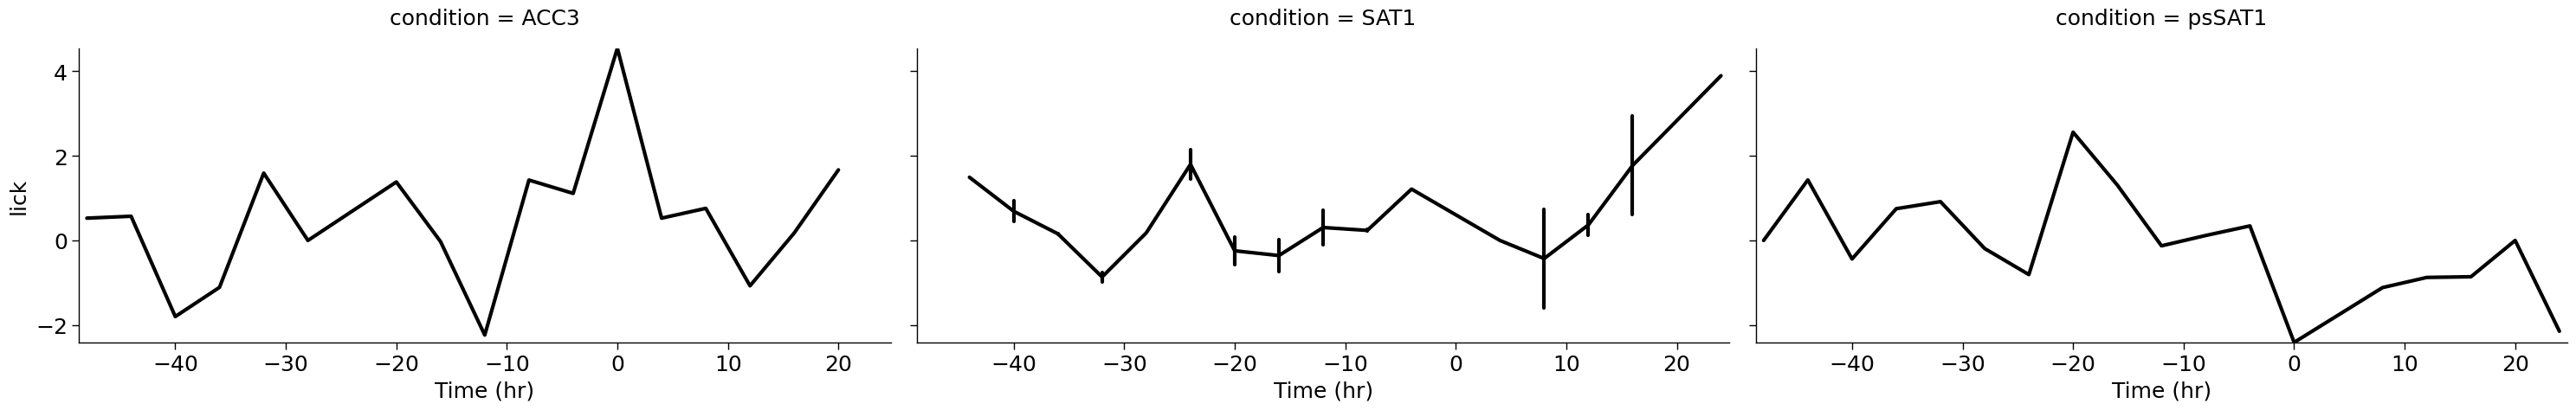

In [178]:
# performance line plot
g = sns.relplot(ant_perf, x="Time (hr)", y="lick", col ="condition",
                kind="line", errorbar="se", err_style="bars", aspect=2, 
                facet_kws={"sharey":True}, color='k')

#### performance bar plot


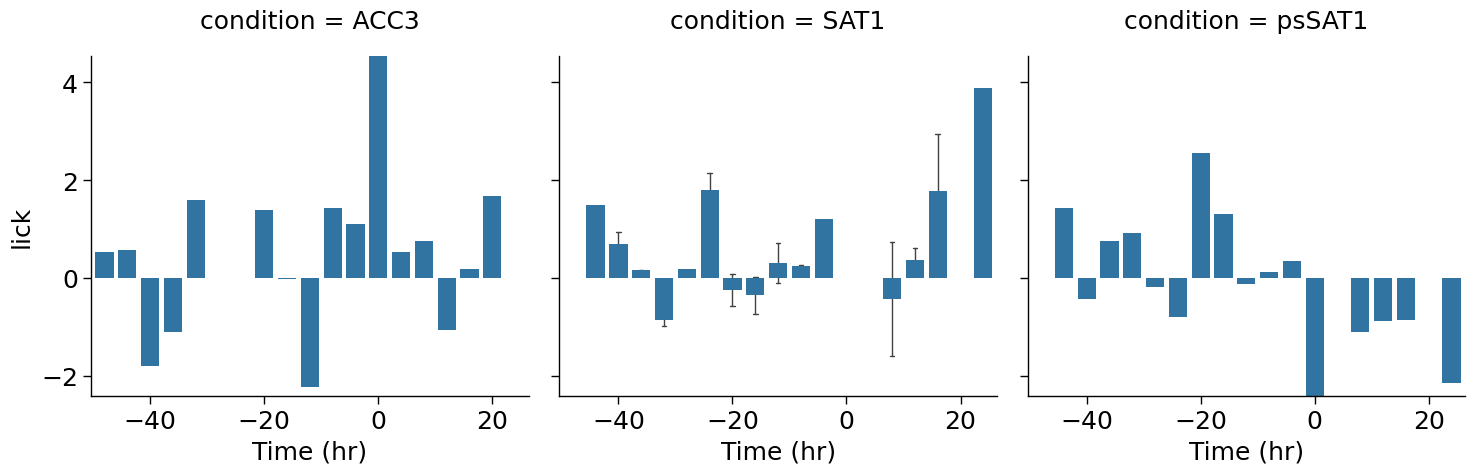

In [179]:
# performance bar plot
g = sns.catplot(ant_perf, x="Time (hr)", y="lick", aspect=1,
                col ="condition", kind="bar", errorbar="se", dodge=False, capsize=0.2,
                err_kws={"zorder":0.5, "lw":1},
                sharex=True, sharey=True, native_scale=True, legend=False)

#### performance across trial (all timebins in one plot)


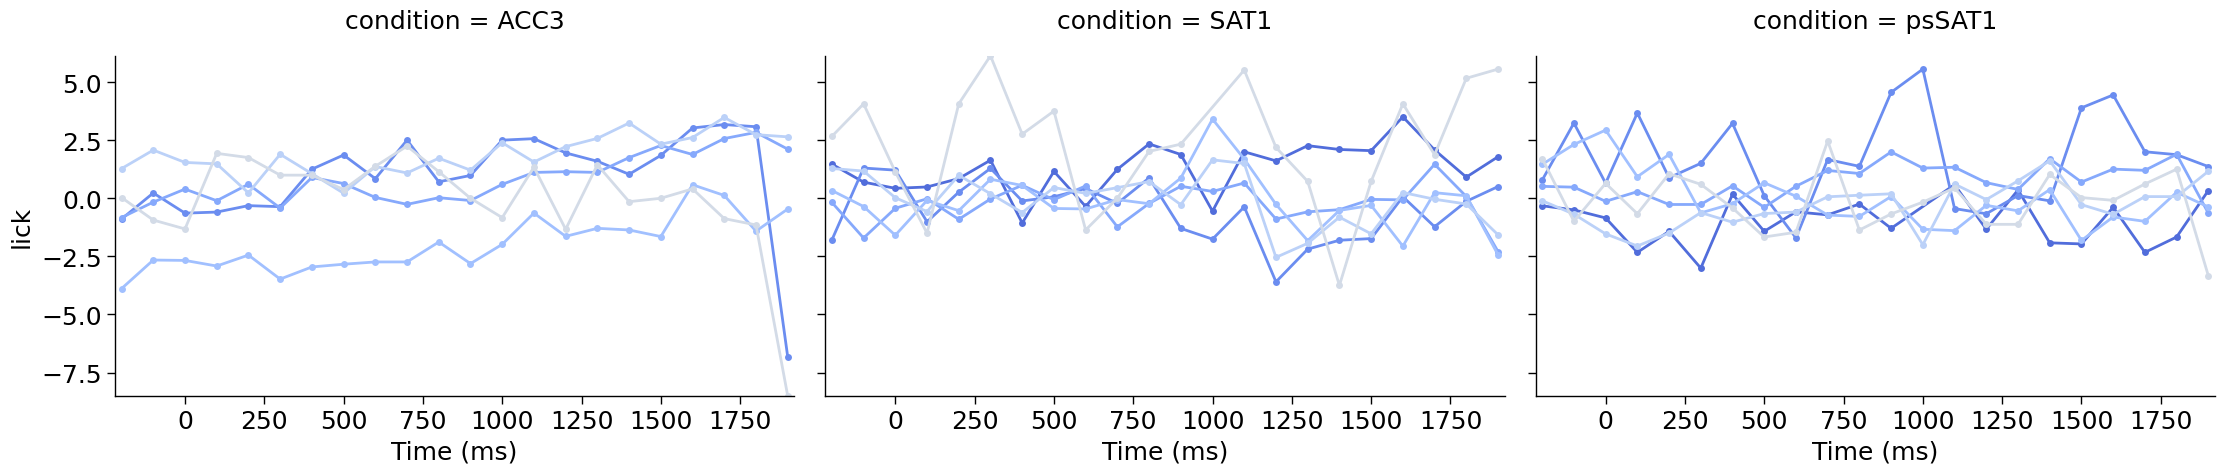

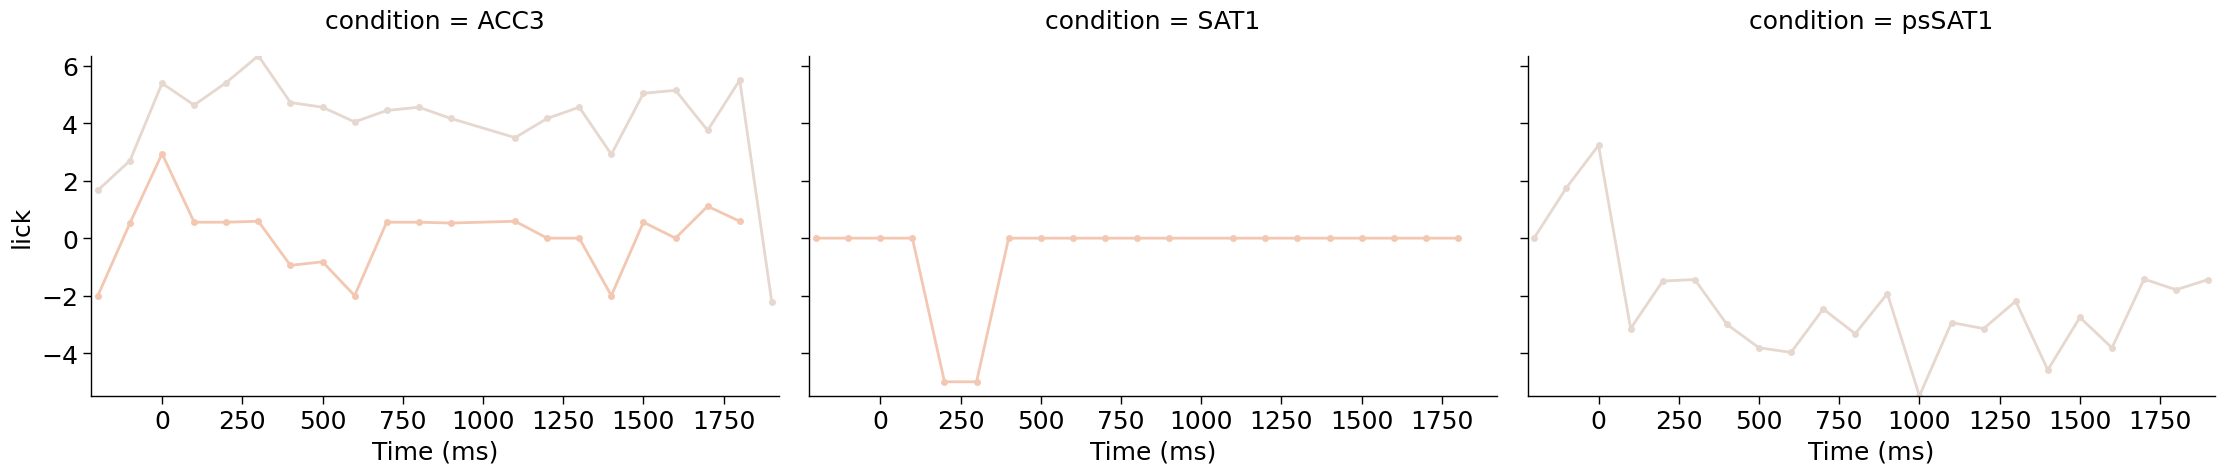

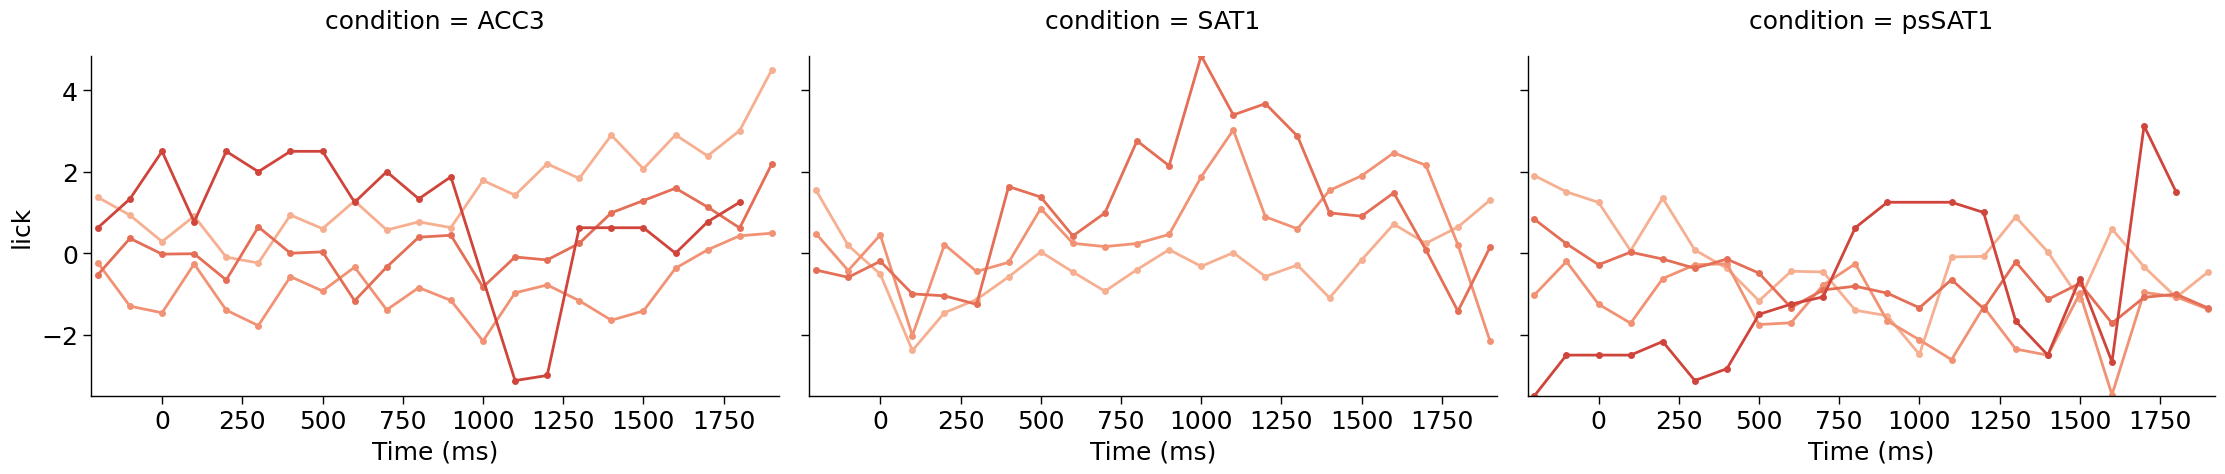

In [180]:
# performance across trial (all timebins in one plot)
pl = sns.color_palette("coolwarm", n_colors=12)
condacc = ( (perf["Time (hr)"] < 0) & (perf["Time (hr)"] >= -24) )
condearly = ( (perf["Time (hr)"] < 8) & (perf["Time (hr)"] >= 0) )
condlate = ( (perf["Time (hr)"] < 24) & (perf["Time (hr)"] >= 8) )

g = sns.relplot(data=perf[condacc], kind="line",x="Time (ms)", y="lick",
                col="condition", hue="Time (hr)", palette=pl[0:6],
                legend=False, errorbar=None, lw=2, marker='o', mec=None,
                facet_kws={"sharex":True, "sharey":True}, aspect=1.5
)


g = sns.relplot(data=perf[condearly], kind="line",x="Time (ms)", y="lick",
                col="condition", hue="Time (hr)", palette=pl[6:8],
                legend=False,  errorbar=None,lw=2,marker='o', mec=None,
                facet_kws={"sharex":True, "sharey":True}, aspect=1.5)


g = sns.relplot(data=perf[condlate], kind="line",x="Time (ms)", y="lick",
                col="condition", hue="Time (hr)", palette=pl[8:],
                legend=False,  errorbar=None,lw=2, marker='o', mec=None,
                facet_kws={"sharex":True, "sharey":True}, aspect=1.5)


#### performance across trial by hour, conditions together


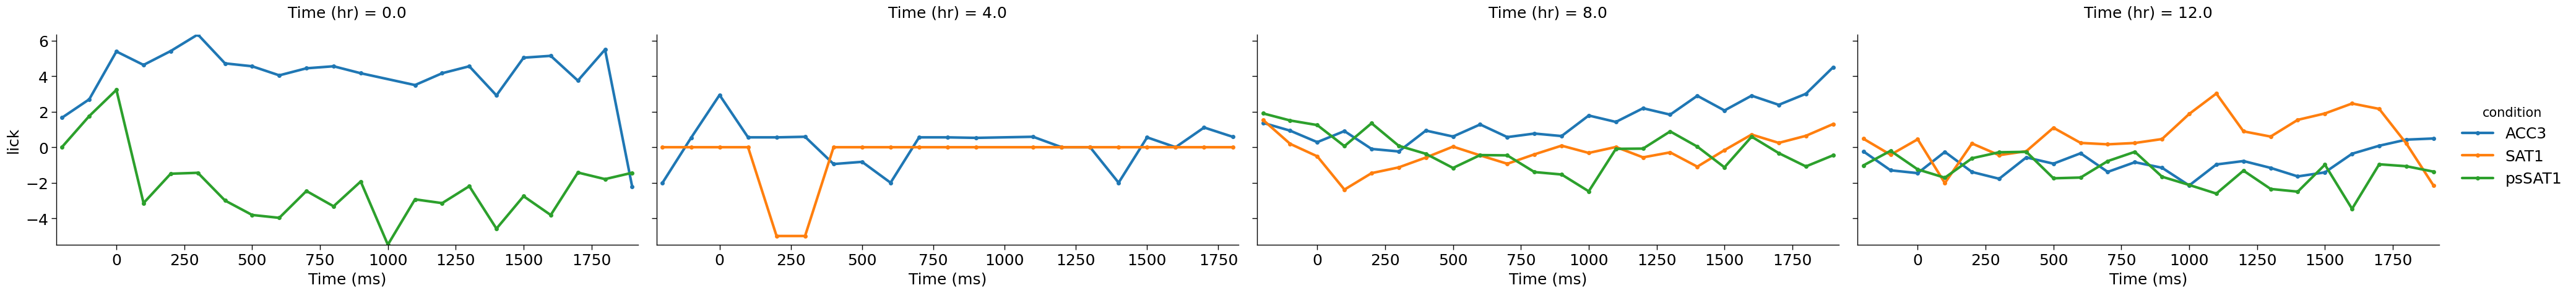

In [181]:
# performance across trial by hour, conditions together
cond = ( (perf["Time (hr)"] >= 0) & (perf["Time (hr)"] <= 12) )
g = sns.relplot(data=perf[cond], kind="line",x="Time (ms)", y="lick",col="Time (hr)", 
                    hue="condition", errorbar=None,
                    marker='o', mec=None, aspect=2,
                    facet_kws={"sharex":False, "sharey":True} )
t_dict = {k:k for k in range(-24, 24, 4)}

### Number of Trials

#### bar plot by day


Text(536.4131944444445, 0.5, '')

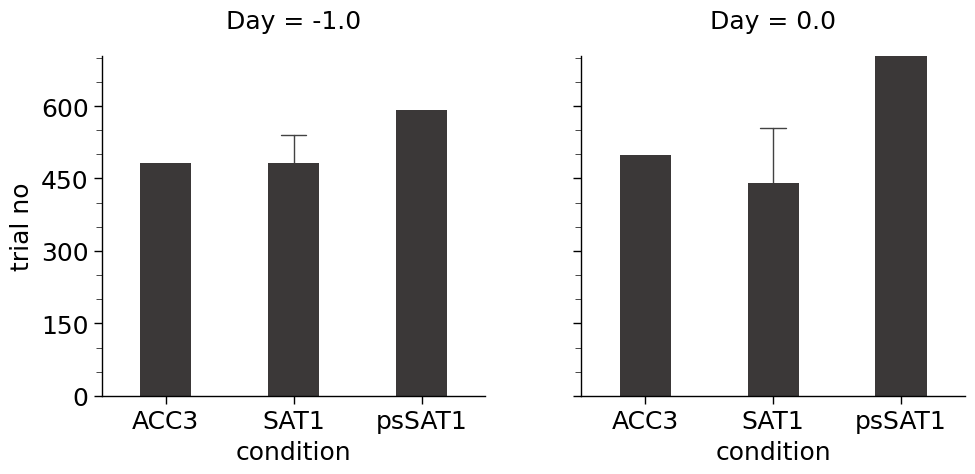

In [182]:
# bar plot by day
total_trials = counts.groupby(["condition","animal", "day_delta"]).sum()["trial no"].reset_index()
time_to_float(total_trials, "Day", "day_delta", "D")
cond = (total_trials["Day"] > -2) & (total_trials["Day"] < 1)

g = sns.catplot(total_trials[cond], x="condition", y="trial no", aspect=1,
                col ="Day", color='#3B3838', sharey=True, capsize=0.2,
                kind="bar", errorbar="se", err_kws={"lw":1, "zorder":0},
                width=0.4)

time_dict = {-1:"ACC", 0:"SAT"}
xlims = [-0.5, 2.5]
ylims = [200, 650]
ylabel = "Number of trials"
for (col_val), ax in g.axes_dict.items():
    t=f"{time_dict[col_val]}"
    ax.yaxis.set_major_locator(ticker.MultipleLocator(150))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))
    ax.tick_params(which='minor', size=4)
g.figure.subplots_adjust(wspace=0.25)
g.axes_dict[0].set_ylabel("")

#### number of total trials line plot

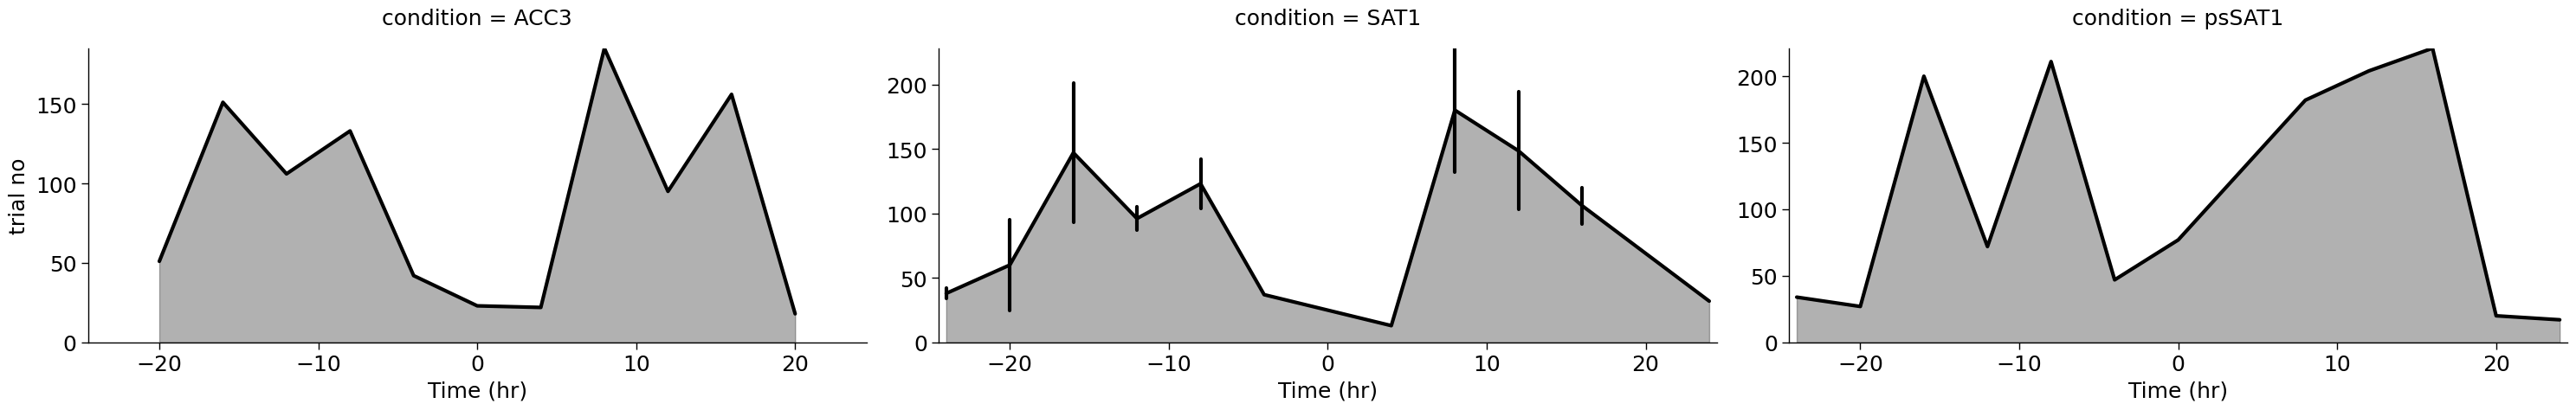

In [183]:
# number of total trials
tt_hr = counts.groupby(["condition", "animal", "Time (hr)"]).sum()["trial no"].reset_index()
cond = (tt_hr["Time (hr)"] <= 24) & (tt_hr["Time (hr)"] >= -24)
g = sns.relplot(tt_hr[cond], x="Time (hr)", y="trial no", col ="condition",
                kind="line", errorbar="se", err_style="bars", aspect=2, 
                facet_kws={"sharey":False}, color='k')
for name, ax in g.axes_dict.items():
    ax.fill_between(ax.lines[0].get_data()[0], ax.lines[0].get_data()[1], color="k", alpha=0.3)

#### bar plot by hour stim and blank

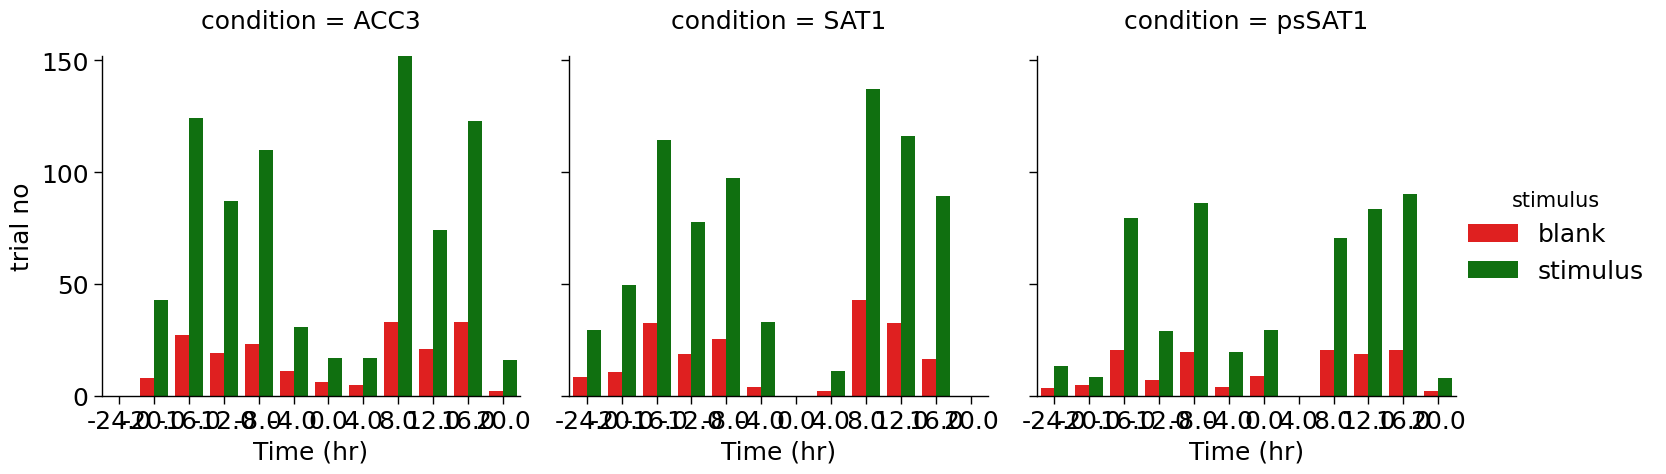

In [184]:
# bar plot by hour stim and blank
cond = (counts["Time (hr)"] < 24) & (counts["Time (hr)"] >= -24)
g = sns.catplot(counts[cond], x="Time (hr)", y="trial no",
                hue="stimulus", col ="condition", palette = ["red", "green"], 
                kind="bar", errorbar=None)

#### number of stimulus and blank trials as stacked plot (average but no error bars)

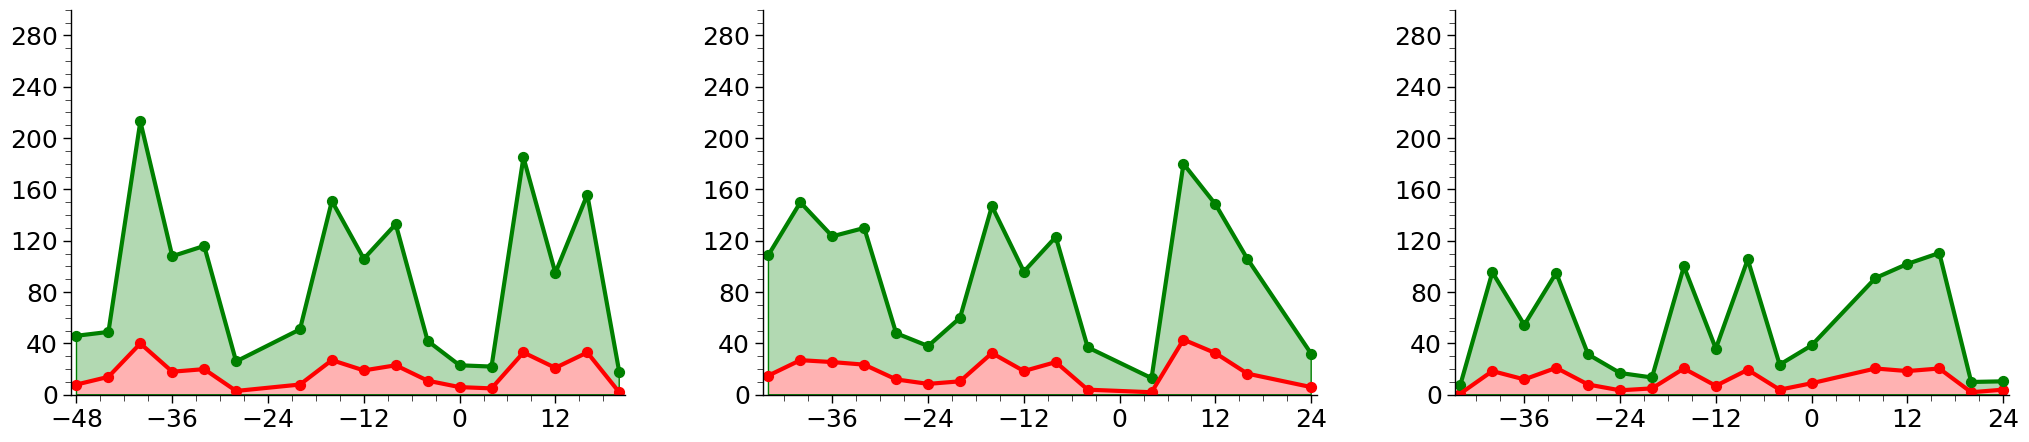

In [185]:
# number of stimulus and blank trials as stacked plot (average but no error bars)
cond = (counts["Time (hr)"] <= 120) & (counts["Time (hr)"] >= -48)
avg_counts = counts[cond]
avg_counts = avg_counts.groupby(["condition", "Time (hr)", "stimulus"])["trial no"].mean().reset_index()

g, axs = plt.subplots(1, 3, figsize=(25,5))
conds = avg_counts["condition"].unique()

ylims = [0, 300]
ymax = ylims[1]

for i in range(len(conds)):
    lab = avg_counts[avg_counts["condition"] == conds[i]]["stimulus"].unique()
    x = avg_counts[(avg_counts["condition"] == conds[i]) & (avg_counts["stimulus"] == lab[0])]["Time (hr)"]
    axs[i].spines[["top", "right"]].set_visible(False)
    y1 = avg_counts[(avg_counts["condition"] == conds[i]) & (avg_counts["stimulus"] == lab[0])]["trial no"].reset_index(drop=True)
    y2 = avg_counts[(avg_counts["condition"] == conds[i]) & (avg_counts["stimulus"] == lab[1])]["trial no"].reset_index(drop=True)
    axs[i].stackplot(x, y1, y2, labels=lab, colors=['#FFB2B2','#B2D9B2'], alpha=1, edgecolor=["green", "red"])
    axs[i].plot(x, y1, color="red")
    axs[i].scatter(x, y1, color="red", s=50)
    axs[i].plot(x, (y1 + y2),color="green")
    axs[i].scatter(x, (y1 + y2), color="green",s=50)    
    ylabel="Number of trials"
    axs[i].set_ylim(ylims)
    axs[i].xaxis.set_major_locator(ticker.MultipleLocator(12))
    axs[i].yaxis.set_major_locator(ticker.MultipleLocator(40))
    axs[i].xaxis.set_minor_locator(ticker.MultipleLocator(3))
    axs[i].yaxis.set_minor_locator(ticker.MultipleLocator(10))
    ax.spines[["bottom", "left"]].set(lw=2)
g.subplots_adjust(wspace=0.25)

#### number of trials per bout

In [186]:
# number of trials per bout
f = data.groupby(["condition", "animal", "Time (hr)", "bout no", "trial no"]).first().reset_index()

counts_prev = f.groupby(["condition","animal", "Time (hr)", "bout no", "stimulus", "1_back"]).count()
cts_gp = counts_prev.groupby(["condition", "animal", "Time (hr)", "stimulus", "1_back"])
mean_prev = cts_gp.mean().reset_index()
total_prev = cts_gp.sum().reset_index()

counts_stim = f.groupby(["condition","animal", "Time (hr)", "bout no", "stimulus"]).count()
cts_gp = counts_stim.groupby(["condition", "animal", "Time (hr)", "stimulus"])
mean_stim = cts_gp.mean().reset_index()
total_stim = cts_gp.sum().reset_index()

counts_all = f.groupby(["condition","animal", "Time (hr)", "bout no"]).count()
mean_all = counts_all.groupby(["condition", "animal", "Time (hr)"]).mean().reset_index()

h = mean_prev[['1_back', 'stimulus']].apply(tuple, axis=1)
p = ["xkcd:burgundy", "xkcd:dark forest green", "xkcd:magenta", "xkcd:turquoise green"]
ordr = [('stimulus', 'blank'),
       ('stimulus', 'stimulus'), ('blank', 'blank'),
       ('blank', 'stimulus')]


#### number of trials by previous trial identity

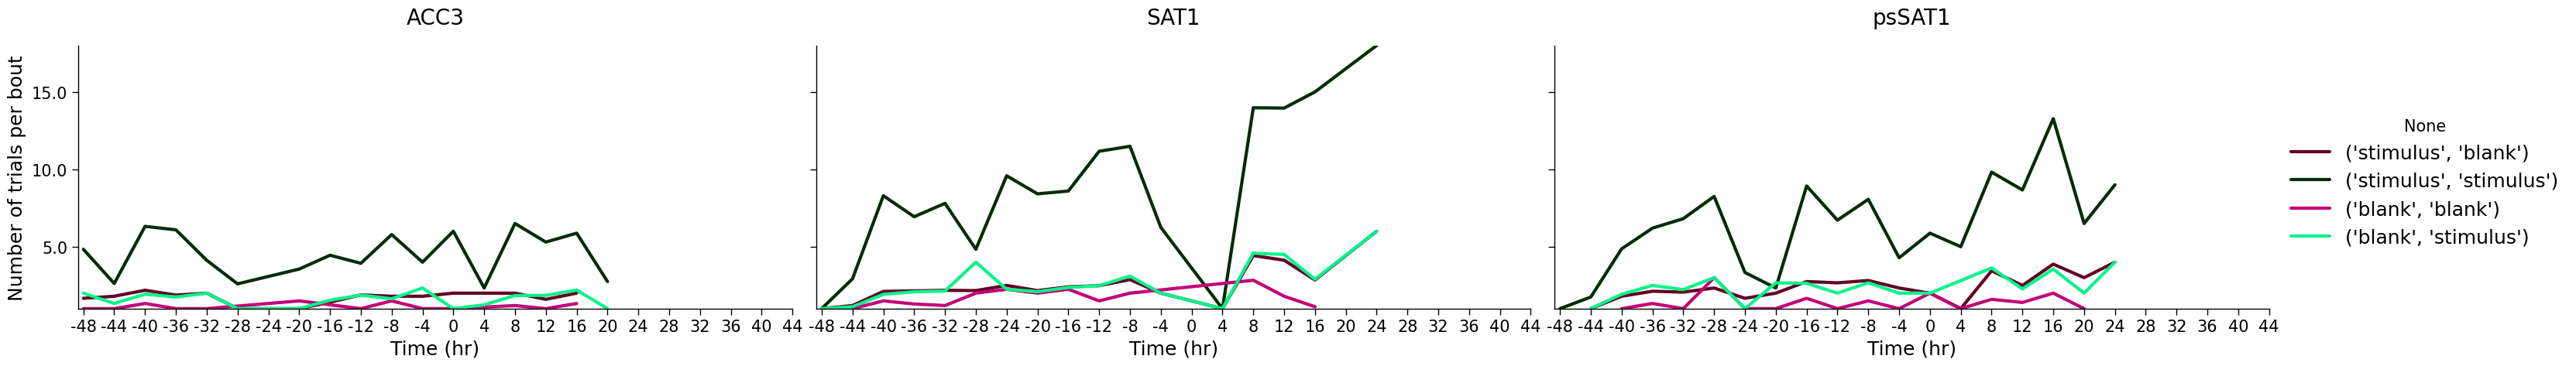

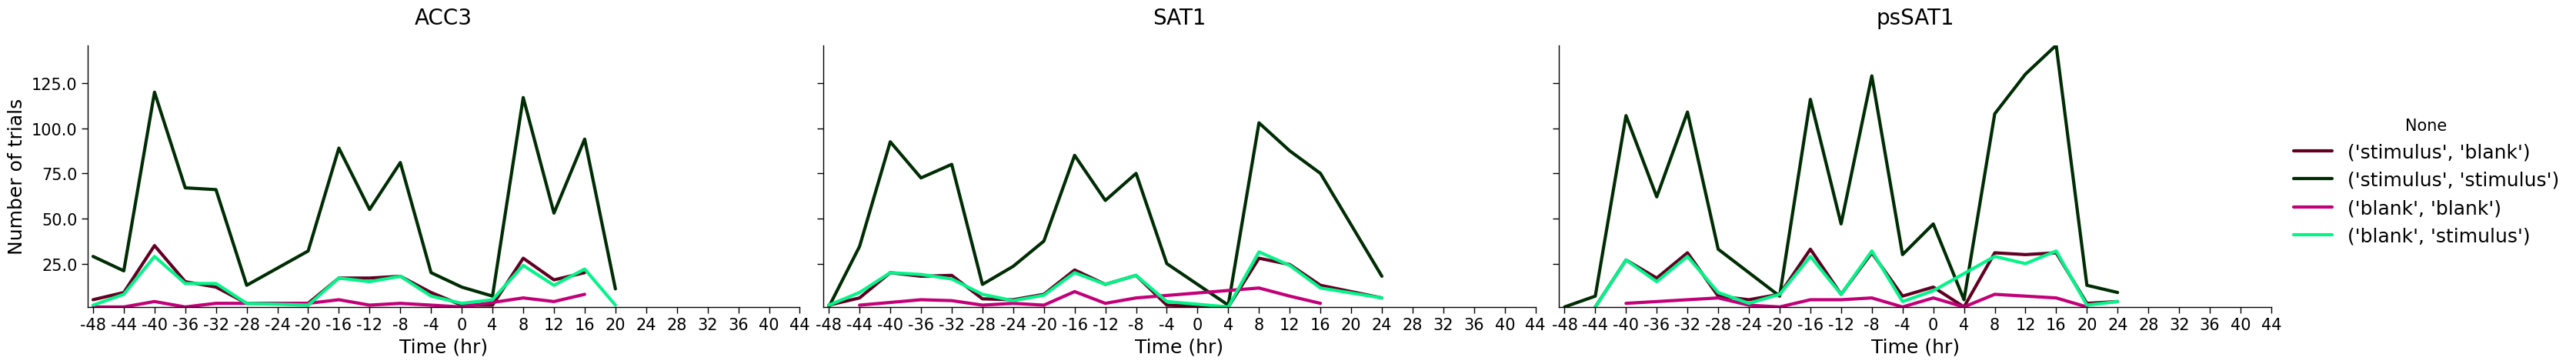

In [187]:
# number of trials by previous trial identity
g = sns.relplot(data=mean_prev, x="Time (hr)", y="lick", col="condition", hue=h, 
                palette=p, hue_order=ordr, kind="line", errorbar=None, aspect=2)
ticks = [i for i in range(-48, 48, 4)]
for (col_val), ax in g.axes_dict.items():
    ax.set_title(f'{col_val}', fontsize=20)
    ax.set_xlabel("Time (hr)", fontsize=18)
    ax.set_ylabel("Number of trials per bout", fontsize=18)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, ha='center', fontsize=15)
    ax.set_yticklabels(ax.get_yticks(), fontsize=15)

g = sns.relplot(data=total_prev, x="Time (hr)", y="lick", col="condition", hue=h, 
                palette=p, hue_order=ordr,kind="line", errorbar=None, aspect=2)
ticks = [i for i in range(-48, 48, 4)]
for (col_val), ax in g.axes_dict.items():
    ax.set_title(f'{col_val}', fontsize=20)
    ax.set_xlabel("Time (hr)", fontsize=18)
    ax.set_ylabel("Number of trials", fontsize=18)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, ha='center', fontsize=15)
    ax.set_yticklabels(ax.get_yticks(), fontsize=15)

### Bout statistics

#### Calculate bout statistics

In [188]:
# calculate bout statistics

# metadata
keep = data.groupby(["animal", "bout no"]).last()[["condition", "age", "sex", "strain", "cage", "Time (hr)", "stimulus"]]

# bout length (time of last sample in bout - time of first sample in bout)
bout_start = data.groupby(["animal", "bout no"]).first()["timestamp"] 
bout_end = data.groupby(["animal", "bout no"]).last()["timestamp"]
bout_end_identity = data.groupby(["animal", "bout no"]).last()[["timestamp","stimulus"]]
bout_len = (bout_end - bout_start).rename("bout len")

# intra bout iti (first sample of trial - last sample of previous trial)
intra_bt_trial_start = data.groupby(["animal", "bout no", "trial no"]).first()["timestamp"]
intra_bt_trial_end = data.groupby(["animal", "bout no", "trial no"]).last()["timestamp"]
intra_bt_iti = (intra_bt_trial_start - intra_bt_trial_end.groupby(["animal", "bout no"]).shift()).rename("intra bout iti")
intra_bt_iti = intra_bt_iti.groupby(["animal", "bout no"]).mean()
num_trials = intra_bt_trial_start.groupby(["animal", "bout no"]).count().rename("num trials")

# inter bout interval (first sample in bout - last sample in previous bout)
ibi = (bout_start - bout_end.groupby(["animal"]).shift()).rename("ibi")

# concat stats and metatdata together
bout_stats = pd.concat([keep, bout_len, ibi, intra_bt_iti, num_trials], axis=1).reset_index()

# convert to float
# handle NaT (i.e. first trial in bout for iti and ibi) by setting to -1 then 
# resetting all values less than 1 to NA 
# (hacky, but works because no iti or ibi should ever be < 0)
bout_stats["bout len"] = bout_stats["bout len"].to_numpy(dtype="timedelta64[ms]").astype("float")/(1000.)
bout_stats["ibi"] = bout_stats["ibi"].to_numpy(dtype="timedelta64[m]", na_value=-1).astype("float")/60.
bout_stats.loc[bout_stats["ibi"] < 0,"ibi"] = pd.NA
bout_stats["intra bout iti"] = bout_stats["intra bout iti"].to_numpy(dtype="timedelta64[ms]", na_value=-1).astype("float")/1000.
bout_stats.loc[bout_stats["intra bout iti"] < 0,"intra bout iti"] = pd.NA

# calculate trial frequency (number of trials/length of bout)
bout_stats["frequency"] = bout_stats["num trials"]/bout_stats["bout len"]

#### Bout length

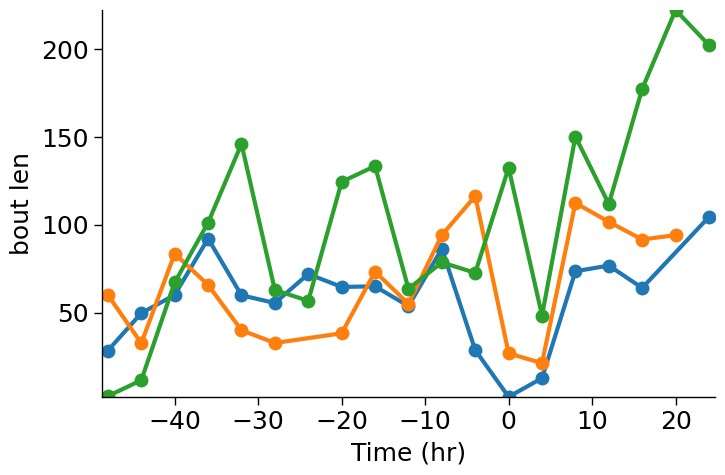

In [189]:
# Bout length
g = sns.relplot(bout_stats, x="Time (hr)", y="bout len", hue="condition", 
                kind="line", errorbar=None, legend=False,
                marker="o", mec=None, ms=10,
                aspect=1.5, facet_kws={"sharey":False})

#### Inter bout interval

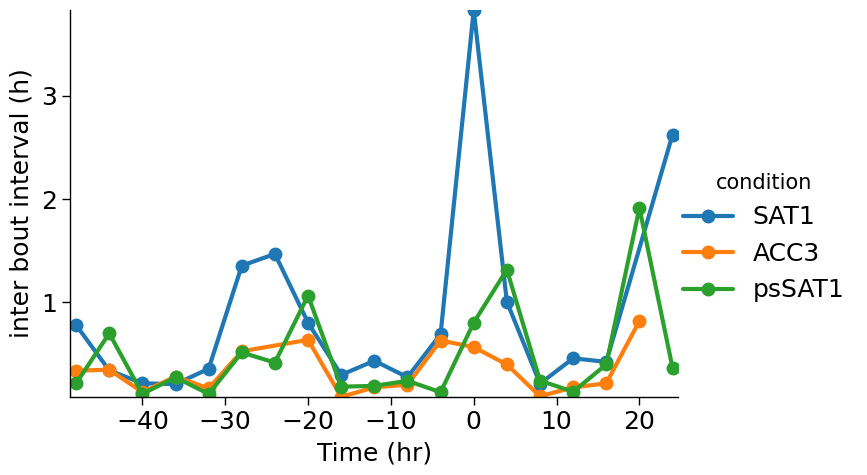

In [190]:
# Inter bout interval
g = sns.relplot(bout_stats, x="Time (hr)", y="ibi", hue="condition", 
                kind="line", errorbar=None, 
                marker="o", mec=None, ms=10,
                facet_kws={"sharey":False}, aspect=1.5)
g.set(ylabel="inter bout interval (h)")

#### Intra-bout inter trial interval

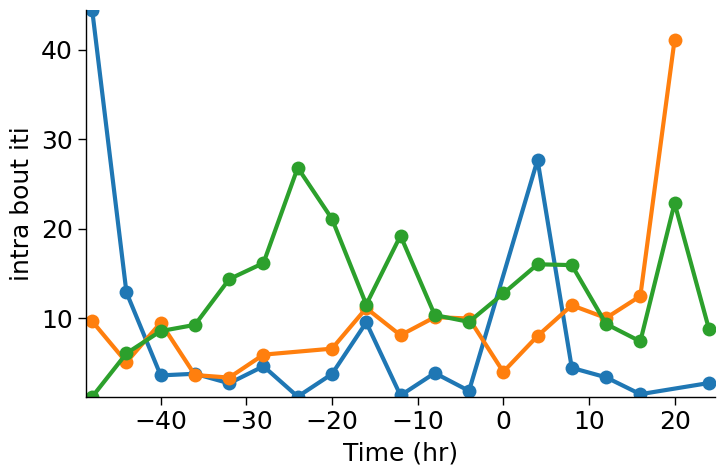

In [191]:
# intra-bout inter trial interval
g = sns.relplot(bout_stats, x="Time (hr)", y="intra bout iti", 
                hue="condition", kind="line", errorbar=None, legend=False,
                marker="o", mec=None, ms=10, aspect=1.5, 
                facet_kws={"sharey":False})

#### Number of trials per bout

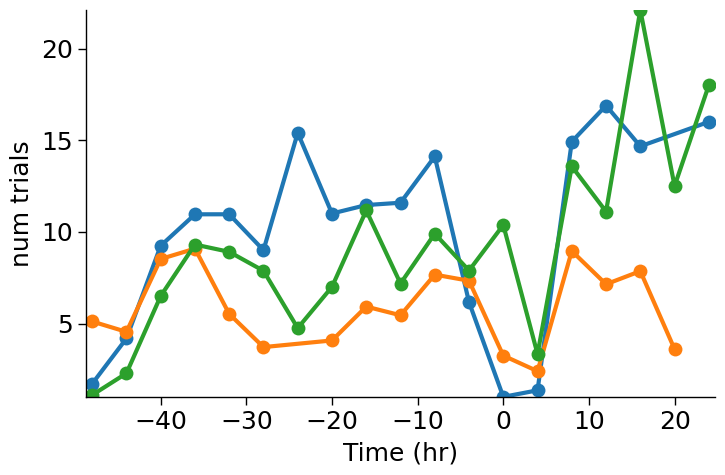

In [192]:
# number of trials per bout
g = sns.relplot(bout_stats, x="Time (hr)", y="num trials", 
                hue="condition", kind="line", errorbar=None, legend=False,
                marker="o", mec=None, ms=10,
                aspect=1.5, facet_kws={"sharey":False})

#### Intra-bout trial frequency

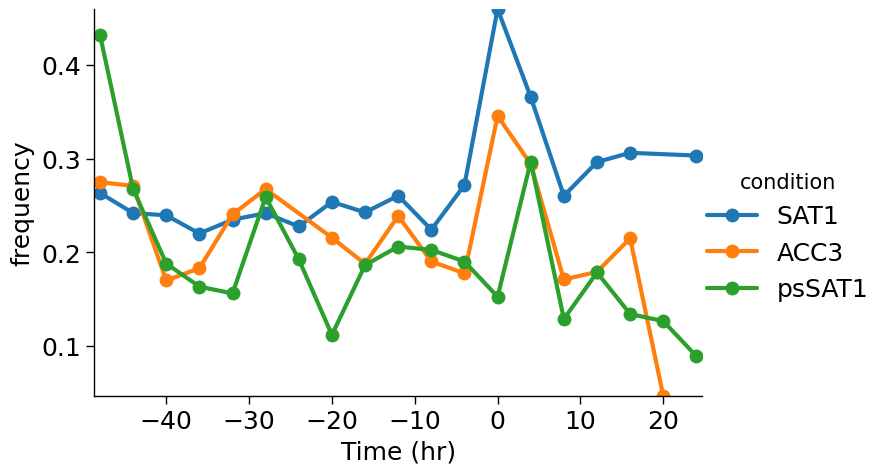

In [193]:
# Intra-bout trial frequency
g = sns.relplot(bout_stats, x="Time (hr)", y="frequency", hue="condition", 
                kind="line", errorbar=None,
                marker="o", mec=None, ms=10,
                aspect=1.5, facet_kws={"sharey":False})

### Lick frequency across trial

####  across trial lick frequency for specific timebins

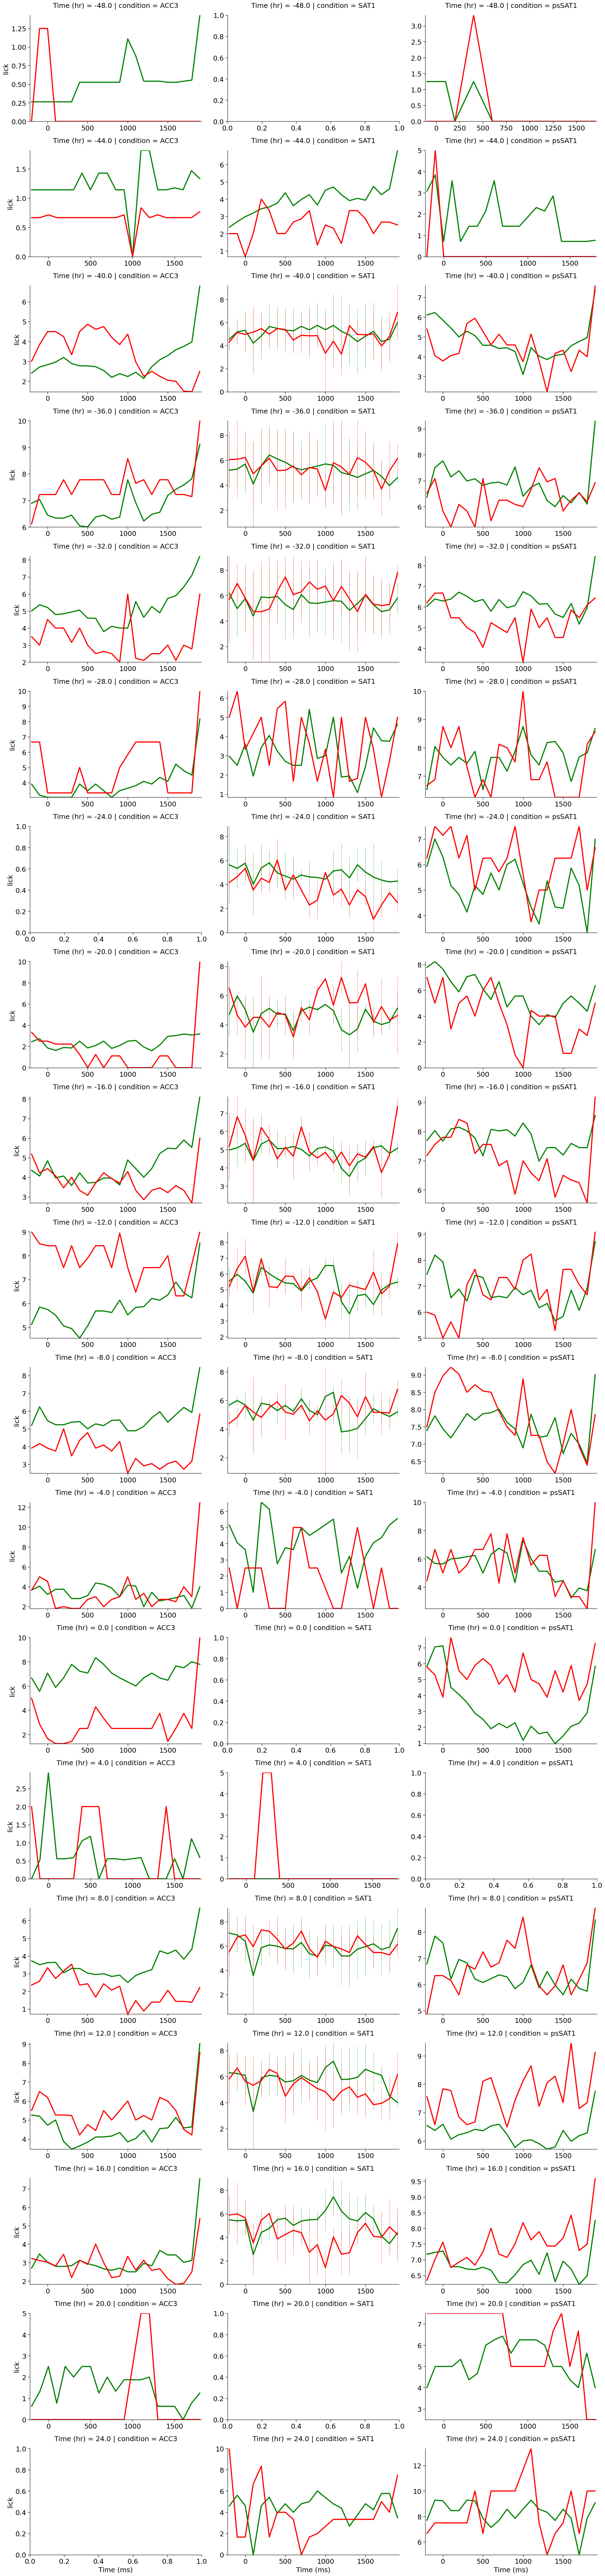

In [194]:
#  across trial lick frequency
#cond = ((mean_statistics["Time (hr)"] == 0) | (mean_statistics["Time (hr)"] == 20))
# plot all timebins average performance trace on the same plot
g = sns.relplot(data=mean_statistics,kind="line",x="Time (ms)", y="lick",
                col="condition", row="Time (hr)", hue="stimulus", 
                palette=["green", "red"], hue_order=["stimulus", "blank"], 
                errorbar="se",err_style="bars", legend=False, aspect=1.5, 
                facet_kws={"sharex":False, "sharey":False}, err_kws={"lw":0.5})

#### anticipatory licking by previous trial contingency


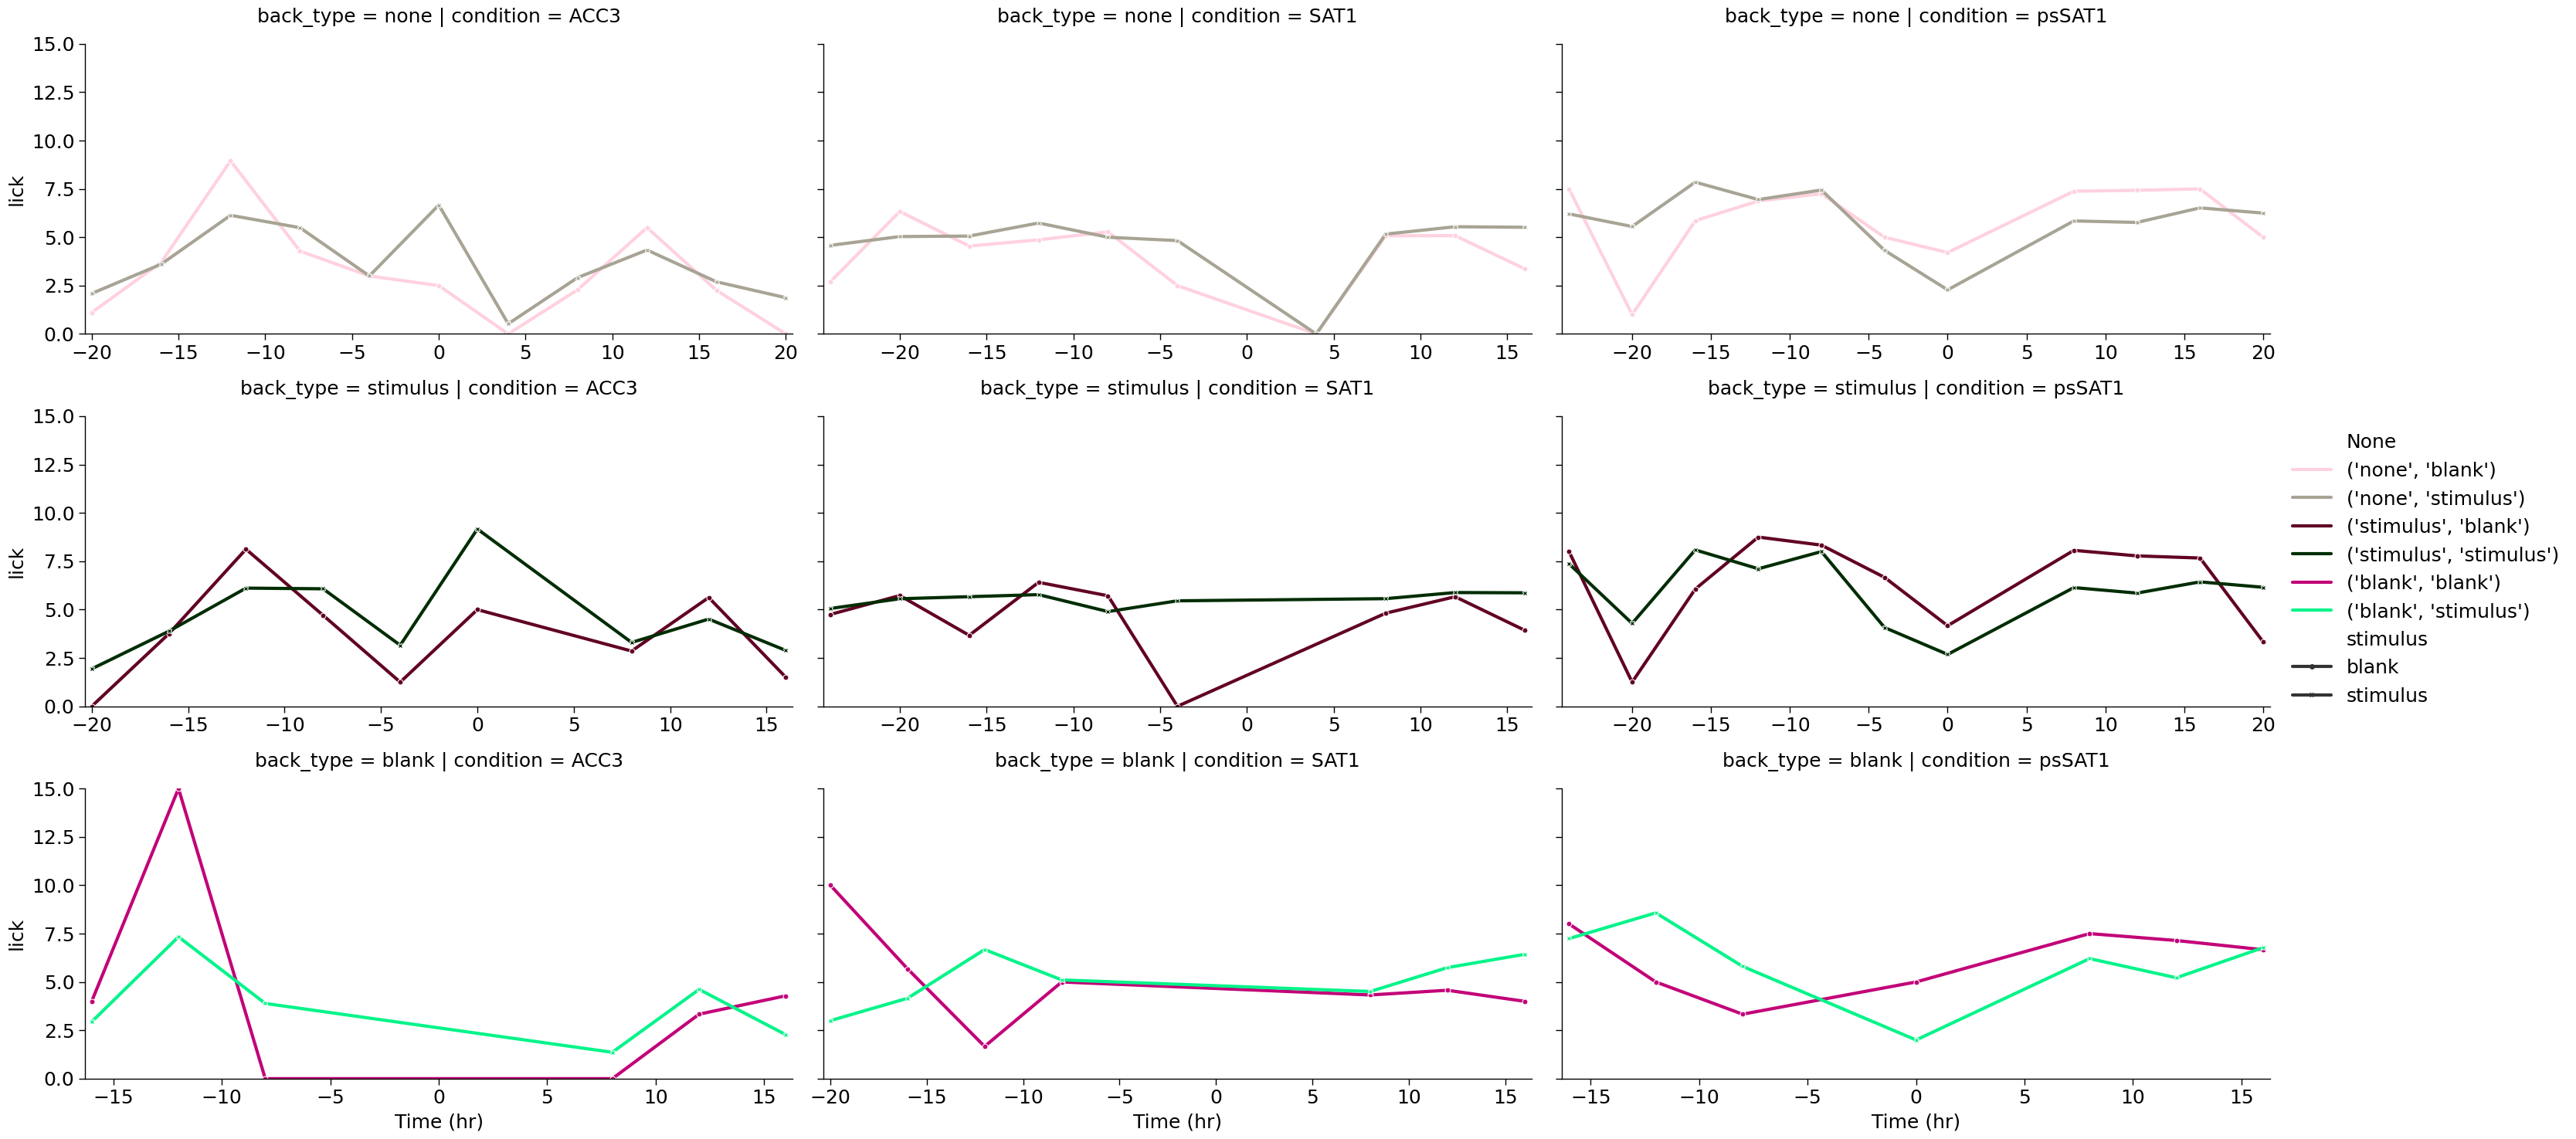

In [195]:
# anticipatory licking by previous trial contingency
ant = mean_w_prev[(mean_w_prev["Time (ms)"] == 900)] 
cond = (ant["Time (hr)"] < 24) & (ant["Time (hr)"] >= -24) & (ant["n_back"] < 2)

h = ant[cond][['back_type', 'stimulus']].apply(tuple, axis=1)
p = ["xkcd:light pink", "xkcd:greyish", "xkcd:burgundy", "xkcd:dark forest green", "xkcd:magenta", "xkcd:turquoise green"]
ordr = [('none', 'blank'), ('none', 'stimulus'), ('stimulus', 'blank'),
       ('stimulus', 'stimulus'), ('blank', 'blank'),
       ('blank', 'stimulus')]

g = sns.relplot(ant[cond], x="Time (hr)", y="lick", 
                hue=h, col ="condition", row="back_type", palette = p, 
                hue_order=ordr, kind="line", errorbar=None, style="stimulus", 
                dashes=False, markers=True, aspect=2, facet_kws={"sharex":False})

#### anticipatory licking by previous trial contingency blank vs blank and stim vs stim


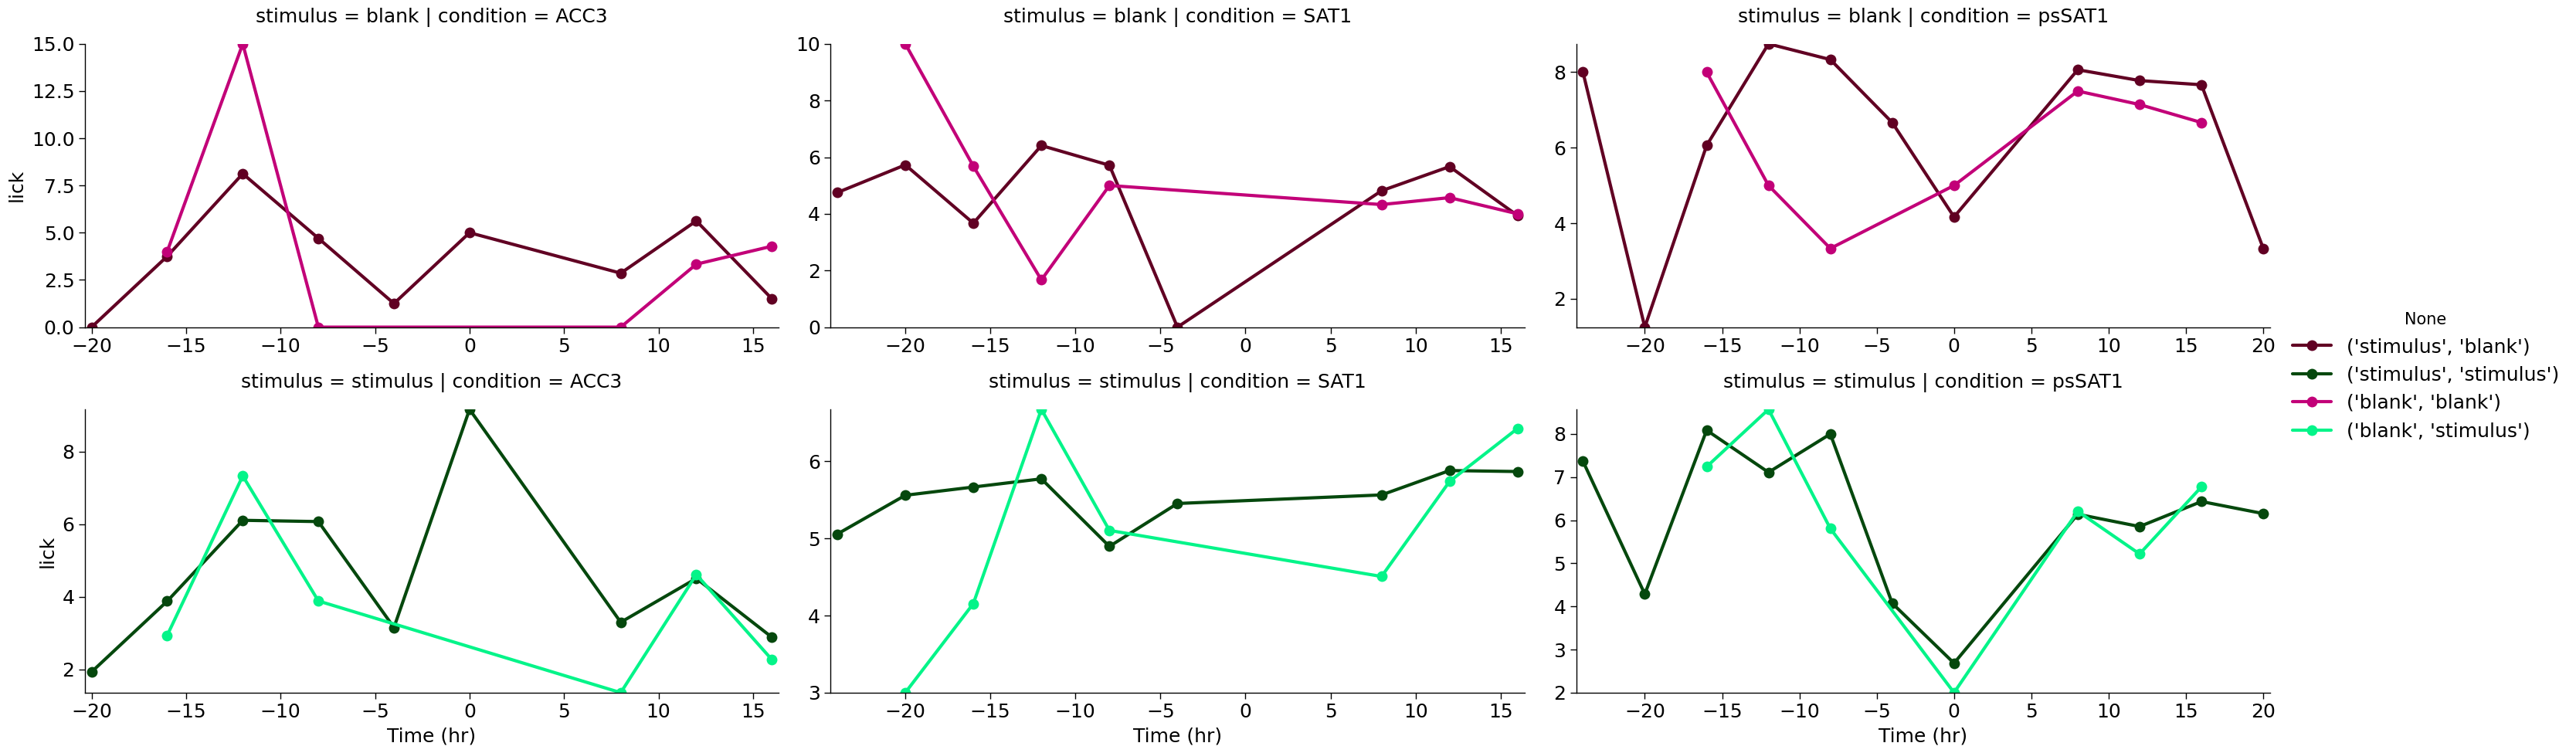

In [196]:
# anticipstory licking by previous trial contingency blank vs blank and stim vs stim
ant = mean_w_prev[(mean_w_prev["Time (ms)"] == 900)] 
prev_palette = ['xkcd:burgundy',
                'xkcd:british racing green',
                'xkcd:magenta',
                'xkcd:turquoise green']

prev_ordr = [('stimulus', 'blank'),
             ('stimulus', 'stimulus'),
             ('blank', 'blank'),
             ('blank', 'stimulus')]

cond = (ant["Time (hr)"] < 24) & (ant["Time (hr)"] >= -24) & (ant["n_back"] < 2) & (ant["back_type"] != "none")

h = ant[cond][['back_type', 'stimulus']].apply(tuple, axis=1)
g = sns.relplot(ant[cond], x="Time (hr)", y="lick", 
                hue=h, col ="condition", row="stimulus", palette = prev_palette, 
                hue_order=prev_ordr, kind="line", errorbar=None, 
                aspect=2, facet_kws={"sharex":False, "sharey":False},
                marker='o', mec=None, ms=10)

### Raster of trial timing (one animal)

Text(0.5, 0, 'Time (min)')

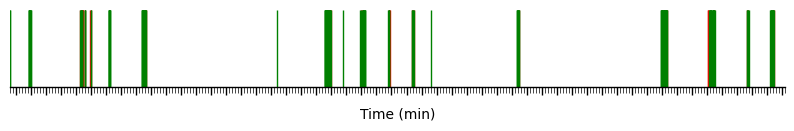

In [197]:
# raster for one animal
a = data[(data["animal"] == "LYO1")]
a = a.groupby("trial no").first().reset_index()
start = datetime.datetime(year=2022, month=3, day=5, hour=19, minute=53)
end = datetime.datetime(year=2022, month=3, day=6, hour=0, minute=11)
a = a[(a["timestamp"] >= start) & (a["timestamp"] <= end)].reset_index(drop=True)
a["relative time"] = a["timestamp"] - a["timestamp"][0]
a = time_to_float(a, "relative time", "relative time", "ms")
a["relative time"] = a["relative time"]/(1000.*60.)
gps = []
for gname, gp in a.groupby(["stimulus"]):
    gps.append(gp["timestamp"])

fig, ax = plt.subplots(1, 1, figsize=(10,1))
c = ["red", "green"]

lo = 0
lw = 1
ll = 1

ax.eventplot(positions=gps, colors=c, lineoffsets=lo, linewidths=lw, linelengths=ll) 
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=1))  
ax.xaxis.set_major_formatter(ticker.NullFormatter())

ax.set_ylim([-0.5,0.5])
ax.set_xlim([start,end])

ax.spines[["left", "right", "top"]].set(visible=False)
ax.yaxis.set_major_locator(ticker.NullLocator())
ax.set_xlabel("Time (min)", fontsize='10')



# 9. Output Results 

This will overwrite any previous output in the same folder, so make sure to 
move files or change the output directory if running the code multiple times.

### a. Aggregate data

In [200]:
output_dir = 'C:\\Users\\swind\\Documents\\lab_work\\Barth\\behavior_analysis\\mouse_analysis\\full_trial_analysis\\example_output\\'
cols = ["condition", "animal", "stimulus", "Time (hr)", "Time (ms)", "lick"]
mean_statistics.to_excel(f'{output_dir}lick_frequency.xlsx', columns=cols, index=False)

cols = ["condition", "animal", "Time (hr)", "stimulus", "trial no"]
counts.to_excel(f'{output_dir}trial_counts.xlsx', columns=cols, index=False)

cols = ["condition", "animal", "Time (hr)", "Time (ms)", "lick"]
perf.to_excel(f'{output_dir}performance.xlsx', columns=cols, index=False)

with open(f'{output_dir}parameters.txt', mode='w') as f:
    out = f'''csv_directory = {csv_directory}
metadata_file = {metadata_file}
default_acc_time = {default_acc_time} days

time_bin = {time_bin} minutes
freq_window = {freq_window} milliseconds, length of rolling window
freq_bin = {freq_bin} milliseconds, length of discrete time bin

min_trials = {min_trials} minimum number of trials in a bin to keep
min_water_trials = {min_water_trials} minimum number of water trials
min_blank_trials = {min_blank_trials} minimum number of water trials
'''
    f.write(out)

### b. Raw lickfrequency data

Takes a long time to run due to large number of samples (~40k rows per animal)

In [201]:
# raw data has too many lines to output to excel
# large number of samples means this takes a long time (~6s for 4 animals)
data.to_csv(f'{output_dir}rawlickfrequency.csv', index=False)

# 10. Pipeline description

__Pipeline:__

>```
>raw data (csv) ------------|    loader.py                                                     lickfreq_analysis                                            
>                            |------------------> formatted data - many animals (dataframe) ---------------------------> trial-level analysis(dataframe)
>metadata (excel) ----------|
>
>                                     aggregate_analysis   |---> trial number counts by timebin and condition (dataframe) ---|
>trial-level analysis (dataframe) ------------------------|---> mean lick frequency by timebin (dataframe) -----------------|---> plots
>                                                          |---> performance by timebin (dataframe) -------------------------|
>```

***

__Formats__

*raw data*

>time (ms), poke, lick, condition code, delay, stimulus

- time measured from start of file
- poke in {0, 1}
- lick in {0, 2}
- condition code in {3, 4, 5, 7, 9}
    - 3 = delay
    - 4 = air delivery
    - 5 = water delivery
    - 7 = after water delivery
    - 9 = blank
- 200 <= delay <= 800
- stimulus in {0, 1}
    - stimulus not present in SAT code
    - stimulus present and relevant in pseudo code

*metadata*

- excel
- must include 'Animal ID' (3 letter + number animal code)
- must include 'acc' (time of acclimation in days)
- other example columns: age, sex, strain

*formatted data*

>timestamp, poke, lick, condition code, delay, trial no, water, stimulus, animal, condition, metadata

- metadata can be multiple columns

*trial-level analysis*
> condition, animal, trial no, puff delta, trial start, timestamp, metadata, stimulus, water, lick, poke, delta, time (hr), time (ms)

- puff delta is equivalent to time (ms)
    - represents timestamp normalized to air delivery
    - puff delta is timedelta and time (ms) is float
- trial start represents timebin as timestamp
- delta is equivalent to time (hr)
    - represents timebin normalized to start of stat
    - delta is timedelta and time (hr) is float
- metadata can be multiple columns
- lick and poke now represent frequencys aggregated based on given window size

